<a href="https://colab.research.google.com/github/jlmarrugom/covid/blob/main/COVID_UC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA Covid 19

Este notebook busca explorar el set de datos de pacientes que se hicieron la prueba de covid-19.

### Requerimientos

In [ ]:
!pip install klib

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import klib

### Importamos los datos

In [ ]:
asin_df = pd.read_excel('/content/drive/MyDrive/Covid UC/CAP_GATEWAY 27 01 2021 NEW.xlsx',sheet_name='BD ASINTOMÁTICOS')
asin_df.head(3)

,COD,PRIMER NOMBRE,SEGUNDO NOMBRE,PRIMER APELLIDO,SEGUNDO APELLIDO,CEDULA,FECHA DE NACIMIENTO,MUNICIPIO,AREA DEL MUNICIPIO,DIRECCIÓN,TELEFONO,EDAD,Rango_etario,ESTADO CIVI,SEXO,AFILIACION AL SGSSS,UPGD,E SOCIOECONOMICO,OCUPACION,LUGAR DE RESIDENCIA,ESCOLARIDAD,CON CUANTAS PERSONAS VIVE,CONVIVE CON PERSONAS MAYOR DE 60 AÑOS,PADECE ALGUNA ENFERMEDAD,CUAL ENFERMEDAD PADECE,TOMA MEDICAMENTOS,CUAL MEDICAMENTO,HA ESTADO ENFERMO A HA TENIDO SÍNTOMAS LOS ÚLTIMOS TRES MESES,FIEBRE Ó ESCALOFRIOS,TOS,DIFICULTAD PARA RESPIRAR,FATIGA,DOLORES MUSCULARES Y CORPORALES,DOLOR DE CABEZA,PERDIDAD DEL OLFATO O DEL GUSTO,DOLOR DE GARGANTA,CONGESTION DE LA NARIZ,NÁUSEAS O VÓMITOS,DIARREA,EN CASO DE HABER ESTADO ENFERMO A QUIEN CONSULTO?,...,CENTRO COMERCIAL,MERCADO,FARMACIA,CENTRO DE SALUD,PARQUE,OTRO CUAL?,YO CREO QUE?,SOBRE LA DURACIÓN?,ESTARÍA DISPUESTO A VACUNARME?,DURANTE EL AISLAMIENTO OBLIGATORIO ME HE SENTIDO?,CAMBIÉ MIS HÁBITOS ALIMENTICIOS,AUMENTE DE PESO,HAGO MENOS EJERCICIO,VEO MÁS TV,SENTÍ TEMOR DE SALIR DE LA CASA,ME HABRIA AISLADO VOLUNTARIAMENTE,PERDÍ MI TRABAJO,RECIBO AYUDA DEL ESTADO,FORTALECÍ MI RELACIÓN CON MI FAMILIA,ESTUVE DE ACUERDO CON LAS MEDIDAS DEL GOBIER2,HE CAMBIADO DE ACTIVIDAD LABORAL?,1 CAMBIÉ TENGO MÁS INGRESOS,¿LA COVID -19 ES?,"FIEBRE,TOS,DOLOR EN EL CUERPO, PERDIDA DE OLFATO","MAREOS, PERDIDA DE APETITO",VOMITOS,SORDERA,EL MAYOR RIESGO LO TIENEN,EL VIRUS SE TRANSMITE POR EL AIRE,SE TRANSMITE POR TOCAR SUPERFICIES EN LA CALLE,SI ME ENFERMO QUE DEBO HACER?,LAVADO DE MANOS,AISLAMIENTO,USO DE TAPABOCAS,DISTANCIAMIENTO SOCIAL,RESULTADO SEROLOGIA,DO,TITULOS,RESULTADO PCR,CQ
0,LH-1,SAIRA,PATRICIA,RAMOS,ARTEAGA,1063137228,1/17/1986,1,2.0,CORREGIMIENTO LOS MONOS,3125374515,34,6,2,2,2,SALUD TOTAL,1,6,1,6,4,3,1,2,1,EUTIROX,2,2,2,2,2,2,2,2,2,2,2,2,5,...,2,2,2,1,2,2,2,3,2,4,2,1,1,1,1,1,1,2,1,1,1,2,1,3,2,2,1,3,1,1,1,1,1,1,1,NEGATIVO,0.103,NaN,NEGATIVO,NaN
1,LH-2,GLADIS,CECILIA,REDONDO,DORIA,1041770457,3/25/1990,1,2.0,CORREGIMIENTO LOS MONOS,3014208989,30,6,3,2,1,NUEVA EPS,1,2,1,6,14,3,2,6,2,NO APLICA,1,1,2,2,2,1,1,1,1,1,2,2,4,...,3,3,3,3,3,3,1,2,2,4,2,2,1,2,1,4,1,1,1,1,1,2,1,3,2,2,1,3,1,1,1,1,1,1,1,POSITIVO,1.317,MEDIO,NEGATIVO,NaN
2,LH-3,RUBEN,DARIO,VEGA,HERNANDEZ,1063152808,1990-01-05 00:00:00,1,2.0,CORREGIMIENTO LOS MONOS - CALLE PRINCIPAL,3116646431,30,6,3,1,1,NUEVA EPS,1,1,3,6,6,1,2,6,2,NO APLICA,2,2,2,2,2,2,2,2,2,2,2,2,5,...,2,2,2,2,2,2,1,1,1,3,2,2,2,2,2,1,2,2,2,1,2,4,1,3,2,2,1,3,1,1,1,1,1,1,1,POSITIVO,2.704,MEDIO,NEGATIVO,NaN


In [ ]:
sin_df = pd.read_excel('/content/drive/MyDrive/Covid UC/CAP SINTOMATICOS 27 01 2021 GATEWAY.xlsx', sheet_name='BD sintomaticos')
sin_df.head(3)

,CÓDIGO,MUNICIPIO,AREA DEL MUNICIPIO,2PO DOCUMENTO,NUM DOCUMENTO,PRIMER NOMBRE,SEGUNDO NOMBRE,PRIMER APELLIDO,SEGUNDO APELLIDO,FECHA DE NACIMIENTO,EDAD,SEXO,TELEFONO,DIRECCIÓN,BARRIO,ESTADO CIVIL,AFILIACION AL SGSSS,EPS,ESTRATO SOCIOECONOMICO,OCUPACIÓN,LUGAR DE RESIDENCIA,ESCOLARIDAD,CON CUANTAS PERSONAS CONVIVE?,CONVIVE CON PERSONA MAYOR DE 60 AÑOS,PADECE ALGUNA ENFERMEDAD?,CUÁL ENFERMEDAD PADECE?,TOMA MEDICAMENTOS,CUÁL MEDICAMENTO?,¿HA ESTADO ENFERMO A HA TENIDO SÍNTOMAS LOS ÚLTIMOS TRES MESES?,FIEBRE Ó ESCALOFRIOS,TOS,DIFICULTAD PARA RESPIRAR,FATIGA,DOLORES MUSCULARES Y CORPORALES,DOLOR DE CABEZA,PERDIDAD DEL OLFATO O DEL GUSTO,DOLOR DE GARGANTA,CONGESTION DE LA NARIZ,NÁUSEAS O VÓMITOS,DIARREA,...,CENTRO COMERCIAL,MERCADO,FARMACIA,CENTRO DE SALUD,PARQUE,OTRO CUAL?,YO CREO QUE?,SOBRE LA DURACIÓN?,ESTARÍA DISPUESTO A VACUNARME?,DURANTE EL AISLAMIENTO OBLIGATORIO ME HE SENTIDO?,CAMBIÉ MIS HÁBITOS ALIMENTICIOS,AUMENTE DE PESO,HAGO ME2S EJERCICIO,VEO MÁS TV,SENTÍ TEMOR DE SALIR DE LA CASA,ME HABRIA AISLADO VOLUNTARIAMENTE,PERDÍ MI TRABAJO,RECIBO AYUDA DEL ESTADO,FORTALECÍ MI RELACIÓN CON MI FAMILIA,ESTUVE DE ACUERDO CON LAS MEDIDAS DEL GOBIER2,HE CAMBIADO DE ACTIVIDAD LABORAL?,SI CAMBIÉ TENGO MÁS INGRESOS,¿LA COVID -19 ES?,"FIEBRE,TOS,DOLOR EN EL CUERPO, PERDIDA DE OLFATO","MAREOS, PERDIDA DE APETITO",VOMITOS,SORDERA,EL MAYOR RIESGO LO TIENEN,EL VIRUS SE TRANSMITE POR EL AIRE,SE TRANSMITE POR TOCAR SUPERFICIES EN LA CALLE,SI ME ENFERMO QUE DEBO HACER?,LAVADO FRECUENTE DE MA2S,AISLAMIENTO,USO DE TAPABOCAS,DISTANCIAMIENTO SOCIAL,RESULTADO PCR,CQ,RESULTADO SEROLOGIA,DO,TITULO
0,LH-153,1,1,3,30666413,LEMIS,DE JESUS,BARRIOS,AVILA,1981-07-02,39,2,NO REGISTRA,NO REGISTRA,NO REGISTRA,5,2,NUEVA EPS,2,1,1,8,7,1,2,6,2,NO APLICA,1,2,1,1,2,1,1,2,1,1,2,2,...,2,2,1,1,2,2,2,1,1,3,3,2,2,2,3,1,2,1,1,2,2,4,1,2,1,2,2,3,2,1,1,1,1,1,1,NEGATIVO,NaN,NEGATIVO,NaN,NaN
1,LH-155,1,1,3,1063146164,SANDY,PAOLA,CABRIA,MARTINEZ,1987-09-19,33,1,NO REGISTRA,NO REGISTRA,NO REGISTRA,1,2,NO REGISTRA,2,1,1,8,4,2,2,6,2,NO APLICA,1,1,1,2,1,1,2,2,1,2,2,2,...,2,2,2,2,2,2,1,1,1,7,1,2,2,2,1,1,2,2,1,1,2,2,1,1,1,1,1,3,1,1,1,1,1,1,1,POSITIVO,25.42,Pendiente,NaN,NaN
2,LH-157,1,1,3,1063172470,PEDRO,ANTONIO,ORTIZ,MONTIEL,1945-11-18,75,2,NO REGISTRA,NO REGISTRA,NO REGISTRA,1,2,SANITAS,2,2,1,7,3,2,2,6,2,NO APLICA,1,2,2,1,1,2,2,2,2,2,2,2,...,2,2,2,2,2,2,1,2,1,4,2,2,2,2,1,1,2,2,1,2,2,1,1,2,2,2,1,4,2,1,1,1,1,1,1,NEGATIVO,NaN,Pendiente,NaN,NaN


In [ ]:
pat_df = pd.concat([asin_df,sin_df],join='inner')
print(pat_df.head(3),'\n',pat_df.tail(3))

  PRIMER NOMBRE SEGUNDO NOMBRE PRIMER APELLIDO  ...     DO  RESULTADO PCR  CQ
0         SAIRA       PATRICIA           RAMOS  ...  0.103       NEGATIVO NaN
1        GLADIS        CECILIA         REDONDO  ...  1.317       NEGATIVO NaN
2         RUBEN          DARIO            VEGA  ...  2.704       NEGATIVO NaN

[3 rows x 75 columns] 
    PRIMER NOMBRE SEGUNDO NOMBRE PRIMER APELLIDO  ...     DO  RESULTADO PCR     CQ
33         JOSE      FRANCISCO          AGUIRRE  ...  0.235       NEGATIVO    NaN
34        MARIA           LUISA         ARRIETA  ...   2.19       POSITIVO  32.83
35     CRISTINA          ISABEL       FRODRIGEZ  ...  1.867       NEGATIVO    NaN

[3 rows x 75 columns]


Veamos que Columnas tienen en común y quedaron luego del inner Join.

In [ ]:
pat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 822 entries, 0 to 35
Data columns (total 75 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   PRIMER NOMBRE                                          822 non-null    object 
 1   SEGUNDO NOMBRE                                         613 non-null    object 
 2   PRIMER APELLIDO                                        822 non-null    object 
 3   SEGUNDO APELLIDO                                       775 non-null    object 
 4   MUNICIPIO                                              822 non-null    int64  
 5   AREA DEL MUNICIPIO                                     794 non-null    float64
 6   DIRECCIÓN                                              822 non-null    object 
 7   TELEFONO                                               822 non-null    object 
 8   EDAD                                               

Analizando objetos.


In [ ]:
print(pat_df['UTILIZA TRANSPORTE PUBLICO'].value_counts(),'\n',
      pat_df['MUNICIPIO'].value_counts(),'\n',
      pat_df['AREA DEL MUNICIPIO'].value_counts(),'\n',
      pat_df['EDAD'].value_counts(),'\n',
      pat_df['OTRO CUAL?'].value_counts(),' Sitio más frecuentado \n',
      pat_df['CASA DE FAMILIARES'].value_counts())

2    563
1    230
4     26
3      2
S      1
Name: UTILIZA TRANSPORTE PUBLICO, dtype: int64 
 4    237
2    167
1    162
3    140
5    116
Name: MUNICIPIO, dtype: int64 
 1.0    536
2.0    244
3.0     14
Name: AREA DEL MUNICIPIO, dtype: int64 
 31    28
26    26
38    24
33    24
43    23
      ..
82     1
76     1
29     1
23     1
46     1
Name: EDAD, Length: 76, dtype: int64 
 2                                  580
3                                  183
TRABAJO                             45
BANCO                                2
EFECTY                               2
1                                    2
CLINICA                              1
DOMICILIOS                           1
VENDEDORA AMBULANTE DE TINTOS        1
CASA DE LOS VECI2S                   1
PARCELA                              1
ENTIDAD QUE ENTREGA EL SUBSIDIO      1
ALCALDIA                             1
ESTACION, CASA                       1
Name: OTRO CUAL?, dtype: int64  Sitio más frecuentado 
 2    447
1    3

Podemos notar que el inner join fue exitoso, y que solo quedamos con las columnas que tienen en común.

El set de datos es un poco desbalanceado entre los pacientes sintomáticos y los asintomáticos, siendo mayor el set de datos asintomático.

Veamos como son los resultados estadísticos preliminares.

In [ ]:
pat_df.describe()

,MUNICIPIO,AREA DEL MUNICIPIO,SEXO,AFILIACION AL SGSSS,LUGAR DE RESIDENCIA,ESCOLARIDAD,TOMA MEDICAMENTOS,FIEBRE Ó ESCALOFRIOS,TOS,DIFICULTAD PARA RESPIRAR,FATIGA,DOLORES MUSCULARES Y CORPORALES,DOLOR DE CABEZA,PERDIDAD DEL OLFATO O DEL GUSTO,DOLOR DE GARGANTA,CONGESTION DE LA NARIZ,NÁUSEAS O VÓMITOS,DIARREA,LA PERSONA CON COVID ESTUVO AISLADA DE LOS DEMAS?,ALGUIEN COMPARTE HABITACION,USAN MEDIDAS DE PROTECCION DENTRO DE LA CASA,USAN MASCARILLAS O CARETAS DENTRO DE LA VIVIENDA,DURANTE LA PANDEMIA ME HE QUEDADO EN CASA,CUANDO LLEGA DE LA CALLE SE QUITA Y LAVA LA ROPA,SE QUITA LOS ZAPATOS O LOS DESINFECTA,PARA MOVILIZARSE UTILIZA ALGUN ELEMENTO DE PROTECCIÓN,DE LOS ELEMENTOS DE PROTECCIÓN,DESINFECTO TODOS LOS PAQUETES QUE LLEGAN,TIENDA,SUPERMERCADO,CENTRO COMERCIAL,MERCADO,FARMACIA,CENTRO DE SALUD,PARQUE,YO CREO QUE?,SOBRE LA DURACIÓN?,ESTARÍA DISPUESTO A VACUNARME?,DURANTE EL AISLAMIENTO OBLIGATORIO ME HE SENTIDO?,CAMBIÉ MIS HÁBITOS ALIMENTICIOS,AUMENTE DE PESO,VEO MÁS TV,SENTÍ TEMOR DE SALIR DE LA CASA,ME HABRIA AISLADO VOLUNTARIAMENTE,PERDÍ MI TRABAJO,RECIBO AYUDA DEL ESTADO,FORTALECÍ MI RELACIÓN CON MI FAMILIA,ESTUVE DE ACUERDO CON LAS MEDIDAS DEL GOBIER2,HE CAMBIADO DE ACTIVIDAD LABORAL?,¿LA COVID -19 ES?,"FIEBRE,TOS,DOLOR EN EL CUERPO, PERDIDA DE OLFATO","MAREOS, PERDIDA DE APETITO",VOMITOS,SORDERA,EL MAYOR RIESGO LO TIENEN,EL VIRUS SE TRANSMITE POR EL AIRE,SE TRANSMITE POR TOCAR SUPERFICIES EN LA CALLE,SI ME ENFERMO QUE DEBO HACER?,AISLAMIENTO,USO DE TAPABOCAS,DISTANCIAMIENTO SOCIAL,CQ
count,822.000000,794.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,822.000000,43.000000
mean,2.973236,1.342569,1.497567,1.690998,1.407543,4.881995,1.796837,1.815085,1.860097,1.920925,1.940389,1.812652,1.779805,1.872263,1.856448,1.884428,1.944039,1.934307,3.367397,3.428224,3.330900,3.386861,2.500000,1.263990,1.552311,1.416058,1.324818,1.701946,1.658151,1.782238,1.993917,1.951338,1.958637,1.923358,2.013382,1.330900,1.929440,2.041363,4.236010,2.013382,1.734793,1.981752,1.855231,2.060827,1.920925,1.762774,1.228710,1.436740,1.929440,1.319951,1.881995,1.875912,1.900243,1.476886,3.025547,1.474453,1.180049,1.425791,1.551095,1.238443,1.326034,31.389654
std,1.358606,0.510694,0.500298,0.778450,0.865127,2.125065,0.479890,0.430128,0.390058,0.323388,0.296301,0.429072,0.451206,0.378451,0.393400,0.366071,0.290796,0.316906,1.144306,1.009857,1.178365,1.120607,1.381759,0.757998,0.945050,0.874394,0.742214,0.984643,0.570211,0.520026,0.325471,0.385570,0.373602,0.413198,0.297887,0.794312,1.110194,1.260567,2.239664,0.922617,0.654959,1.014347,1.002902,1.373562,0.470649,0.532433,0.530441,0.837759,0.654701,0.615327,0.621923,0.566356,0.547189,0.683065,0.301162,0.593267,0.533132,0.947446,0.514532,0.443199,0.484376,6.523196
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000
25%,2.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0000

Para ver los datos faltantes, la librería Klib es de bastante ayuda.

Displaying only columns with missing values.


GridSpec(6, 6)

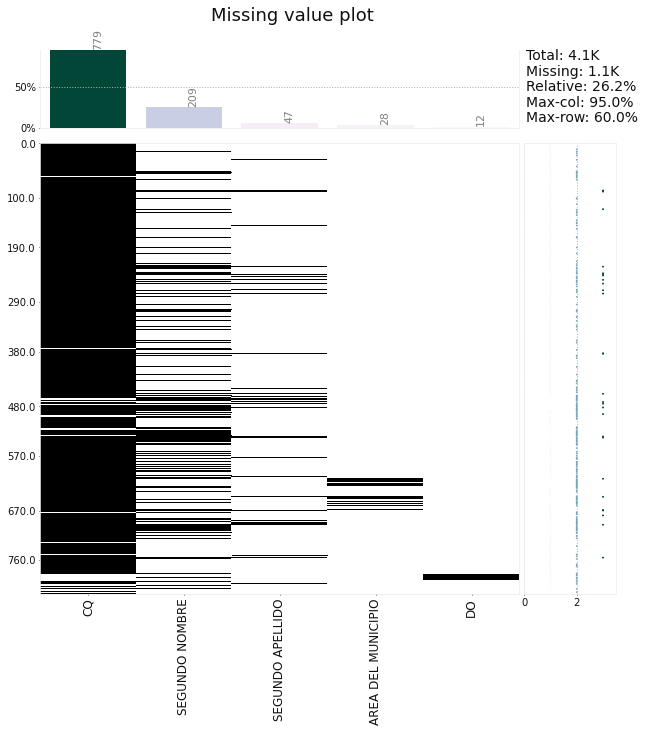

In [ ]:
klib.missingval_plot(pat_df, figsize=(10,10), sort=True)

Los datos faltantes son datos de identificación de la persona, como su segundo nombre y su segundo apellido, el area del municipio deonde vive, y los resultados de las pruebas CQ y DO.

Para el modelado, podemos descartar la prueba CQ, ya que tiene una tasa de datos faltantes cercana o mayor al 60%. Descartar o no las columnas correspondientes a identificadores es opcional. Las columnas correspondientes al **Area del municipio** y al **DO** pueden ser de utilidad para las clasificaciones y extracción de patrones.

### Data Handling

In [ ]:
pat_df['AREA DEL MUNICIPIO'] = pat_df['AREA DEL MUNICIPIO'].fillna(2) # En general los datos que faltaron correspondieron a zonas rurales

In [ ]:
pat_df = pat_df.drop(['SEGUNDO NOMBRE', 'SEGUNDO APELLIDO','CQ'],axis=1)

Faltan algunas pruebas.


In [ ]:
no_data = pat_df.loc[(pat_df['RESULTADO PCR']=='NO LLEGO MUESTRA') |
                     (pat_df['RESULTADO SEROLOGIA'] == 'NO LLEGO MUESTRA')|
                     (pat_df['RESULTADO SEROLOGIA'] == 'Pendiente')]
no_data.head(3)

,PRIMER NOMBRE,PRIMER APELLIDO,MUNICIPIO,AREA DEL MUNICIPIO,DIRECCIÓN,TELEFONO,EDAD,SEXO,AFILIACION AL SGSSS,LUGAR DE RESIDENCIA,ESCOLARIDAD,TOMA MEDICAMENTOS,FIEBRE Ó ESCALOFRIOS,TOS,DIFICULTAD PARA RESPIRAR,FATIGA,DOLORES MUSCULARES Y CORPORALES,DOLOR DE CABEZA,PERDIDAD DEL OLFATO O DEL GUSTO,DOLOR DE GARGANTA,CONGESTION DE LA NARIZ,NÁUSEAS O VÓMITOS,DIARREA,LA PERSONA CON COVID ESTUVO AISLADA DE LOS DEMAS?,ALGUIEN COMPARTE HABITACION,USAN MEDIDAS DE PROTECCION DENTRO DE LA CASA,USAN MASCARILLAS O CARETAS DENTRO DE LA VIVIENDA,DURANTE LA PANDEMIA ME HE QUEDADO EN CASA,CUANDO LLEGA DE LA CALLE SE QUITA Y LAVA LA ROPA,SE QUITA LOS ZAPATOS O LOS DESINFECTA,UTILIZA TRANSPORTE PUBLICO,PARA MOVILIZARSE UTILIZA ALGUN ELEMENTO DE PROTECCIÓN,DE LOS ELEMENTOS DE PROTECCIÓN,DESINFECTO TODOS LOS PAQUETES QUE LLEGAN,CASA DE FAMILIARES,TIENDA,SUPERMERCADO,CENTRO COMERCIAL,MERCADO,FARMACIA,CENTRO DE SALUD,PARQUE,OTRO CUAL?,YO CREO QUE?,SOBRE LA DURACIÓN?,ESTARÍA DISPUESTO A VACUNARME?,DURANTE EL AISLAMIENTO OBLIGATORIO ME HE SENTIDO?,CAMBIÉ MIS HÁBITOS ALIMENTICIOS,AUMENTE DE PESO,VEO MÁS TV,SENTÍ TEMOR DE SALIR DE LA CASA,ME HABRIA AISLADO VOLUNTARIAMENTE,PERDÍ MI TRABAJO,RECIBO AYUDA DEL ESTADO,FORTALECÍ MI RELACIÓN CON MI FAMILIA,ESTUVE DE ACUERDO CON LAS MEDIDAS DEL GOBIER2,HE CAMBIADO DE ACTIVIDAD LABORAL?,¿LA COVID -19 ES?,"FIEBRE,TOS,DOLOR EN EL CUERPO, PERDIDA DE OLFATO","MAREOS, PERDIDA DE APETITO",VOMITOS,SORDERA,EL MAYOR RIESGO LO TIENEN,EL VIRUS SE TRANSMITE POR EL AIRE,SE TRANSMITE POR TOCAR SUPERFICIES EN LA CALLE,SI ME ENFERMO QUE DEBO HACER?,AISLAMIENTO,USO DE TAPABOCAS,DISTANCIAMIENTO SOCIAL,RESULTADO SEROLOGIA,DO,RESULTADO PCR
91,GEOVANNY,BRAVO,1,2.0,CRA 14#15B-09,310496107,26,1,2,1,7,2,2,2,2,2,2,2,2,1,2,2,2,1,2,1,1,4,1,1,2,2,2,1,2,2,2,2,2,2,2,2,0,1,1,1,4,1,1,1,1,1,2,2,1,1,2,1,1,2,2,2,3,2,1,1,1,1,1,NO LLEGO MUESTRA,NO LLEGO MUESTRA,0
108,JOSE,GUITIERREZ,1,2.0,LA DOCTRINA,3006997945,3,1,2,1,5,2,1,1,2,2,2,2,2,1,2,2,2,4,4,4,4,4,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,3,1,1,2,1,1,2,1,2,1,1,1,2,2,2,2,2,1,3,2,1,1,2,2,1,NO LLEGO MUESTRA,NO LLEGO MUESTRA,0
124,EDER,JAIRO,1,1.0,CASCADA,3003928964,48,1,2,1,7,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,1,1,2,1,1,1,2,2,2,2,2,1,2,2,2,4,4,5,6,4,3,4,4,1,2,2,1,2,2,1,3,3,3,3,3,1,1,1,2,1,2,NO LLEGO MUESTRA,NO LLEGO MUESTRA,0


In [ ]:
pat_df = pat_df.drop(index=no_data.index)
pat_df['RESULTADO PCR'].value_counts()

0    762
1     35
Name: RESULTADO PCR, dtype: int64

Para que las variables categoricas pasen a ser numéricas, usaremos la siguiente función.

In [ ]:
def stringtonum():
        #organized in such way that follows the relationships

    pcr = pat_df['RESULTADO PCR'].astype(object).replace({'NEGATIVO': 0, 'POSITIVO': 1})
    sero = pat_df['RESULTADO SEROLOGIA'].astype(object).replace({'NEGATIVO': 0, 'POSITIVO':1})
    casa = pat_df['CASA DE FAMILIARES'].astype(object).replace({'X':0})
    otro = pat_df['OTRO CUAL?'].astype(object).replace({'TRABAJO': 0,'BANCO':4,'EFECTY':4,'CLINICA':7,'DOMICILIOS':6,
                                         'VENDEDORA AMBULANTE DE TINTOS':6,'CASA DE LOS VECI2S':5,
                                         'PARCELA':5,'ENTIDAD QUE ENTREGA EL SUBSIDIO':4,
                                         'ALCALDIA':4, 'ESTACION, CASA':5})
    edad = pat_df['EDAD'].astype(object).replace({'NO REGISTRA':31})#La moda
    utp = pat_df['UTILIZA TRANSPORTE PUBLICO'].astype(object).replace({'S':4})

    pat_df['RESULTADO PCR'] = pd.to_numeric(pcr)
    pat_df['RESULTADO SEROLOGIA'] = pd.to_numeric(sero)
    pat_df['CASA DE FAMILIARES'] = pd.to_numeric(casa)
    pat_df['OTRO CUAL?'] = pd.to_numeric(otro)
    pat_df['EDAD'] = pd.to_numeric(edad)
    pat_df['UTILIZA TRANSPORTE PUBLICO'] = pd.to_numeric(utp)

In [ ]:
stringtonum()


1. La dirección de residencia debemos mapearla a coordenadas.
2. El primer nombre, el apellido, el telefono los podemos descartar del set de datos.
3. Usaremos para el analisis exploratorio un modelo XGBoost, ya que este trata con los Nan, las categorías y los objetos sin problemas, es un modelo robusto, y nos puede indicar qué características son las más influyentes para la predicción.







In [ ]:
ready_df = pat_df.drop(['PRIMER NOMBRE','PRIMER APELLIDO','TELEFONO','DO','DIRECCIÓN'],axis=1)

Para el modelado es una buena practica quitar los espacios de los nombres de las caracteristicas.

In [ ]:
ready_df.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)

Antes de avanzar, hay que aclarar que en el set de datos existen 2 target.

**Resultados PCR**: La prueba PCR (Polimerase Chain Reaction) detecta si hay ARN del virus en la muestra que se toma, los resultados se obtienen entre 2 y 3 horas desde la prueba. Se toma una muestra del sistema respiratorio. Permite diferenciar entre 2 microrganismos similares, es muy *sensible*, detectando hasta 20 copias/mL, y en general se usa para detectar el virus en las *primeras fases* respiratorias.

**Resultados Serología**: La prueba de Serología, o prueba rápida, busca detectar los anticuerpos, generalmente se hace con muestras de sangre, aunque también las hay con muestras respiratorias, y tardan entre 10 y 15 minutos en arrojar resultados. 

Hay que tener en cuenta que en algunos casos puede tardar *3 semanas* para desarrollar los anticuerpos, por lo que la prueba de serología no debe hacerse muy pronto, pero esta permite saber si se tuvo el virus hasta varios meses después.

En la primera fase del proyecto, nos centraremos en predecir los resultados de la prueba PCR, ya que de cierta forma un paciente hospitalario con un sindrome respiratorio agudo estaría más interesado en su estado actual, y la prueba de Serología al tomarse en las primeras etapas, o las etapas críticas, puede arrojar **Falsos negativos**.



Analicemos la correlación entre las características.


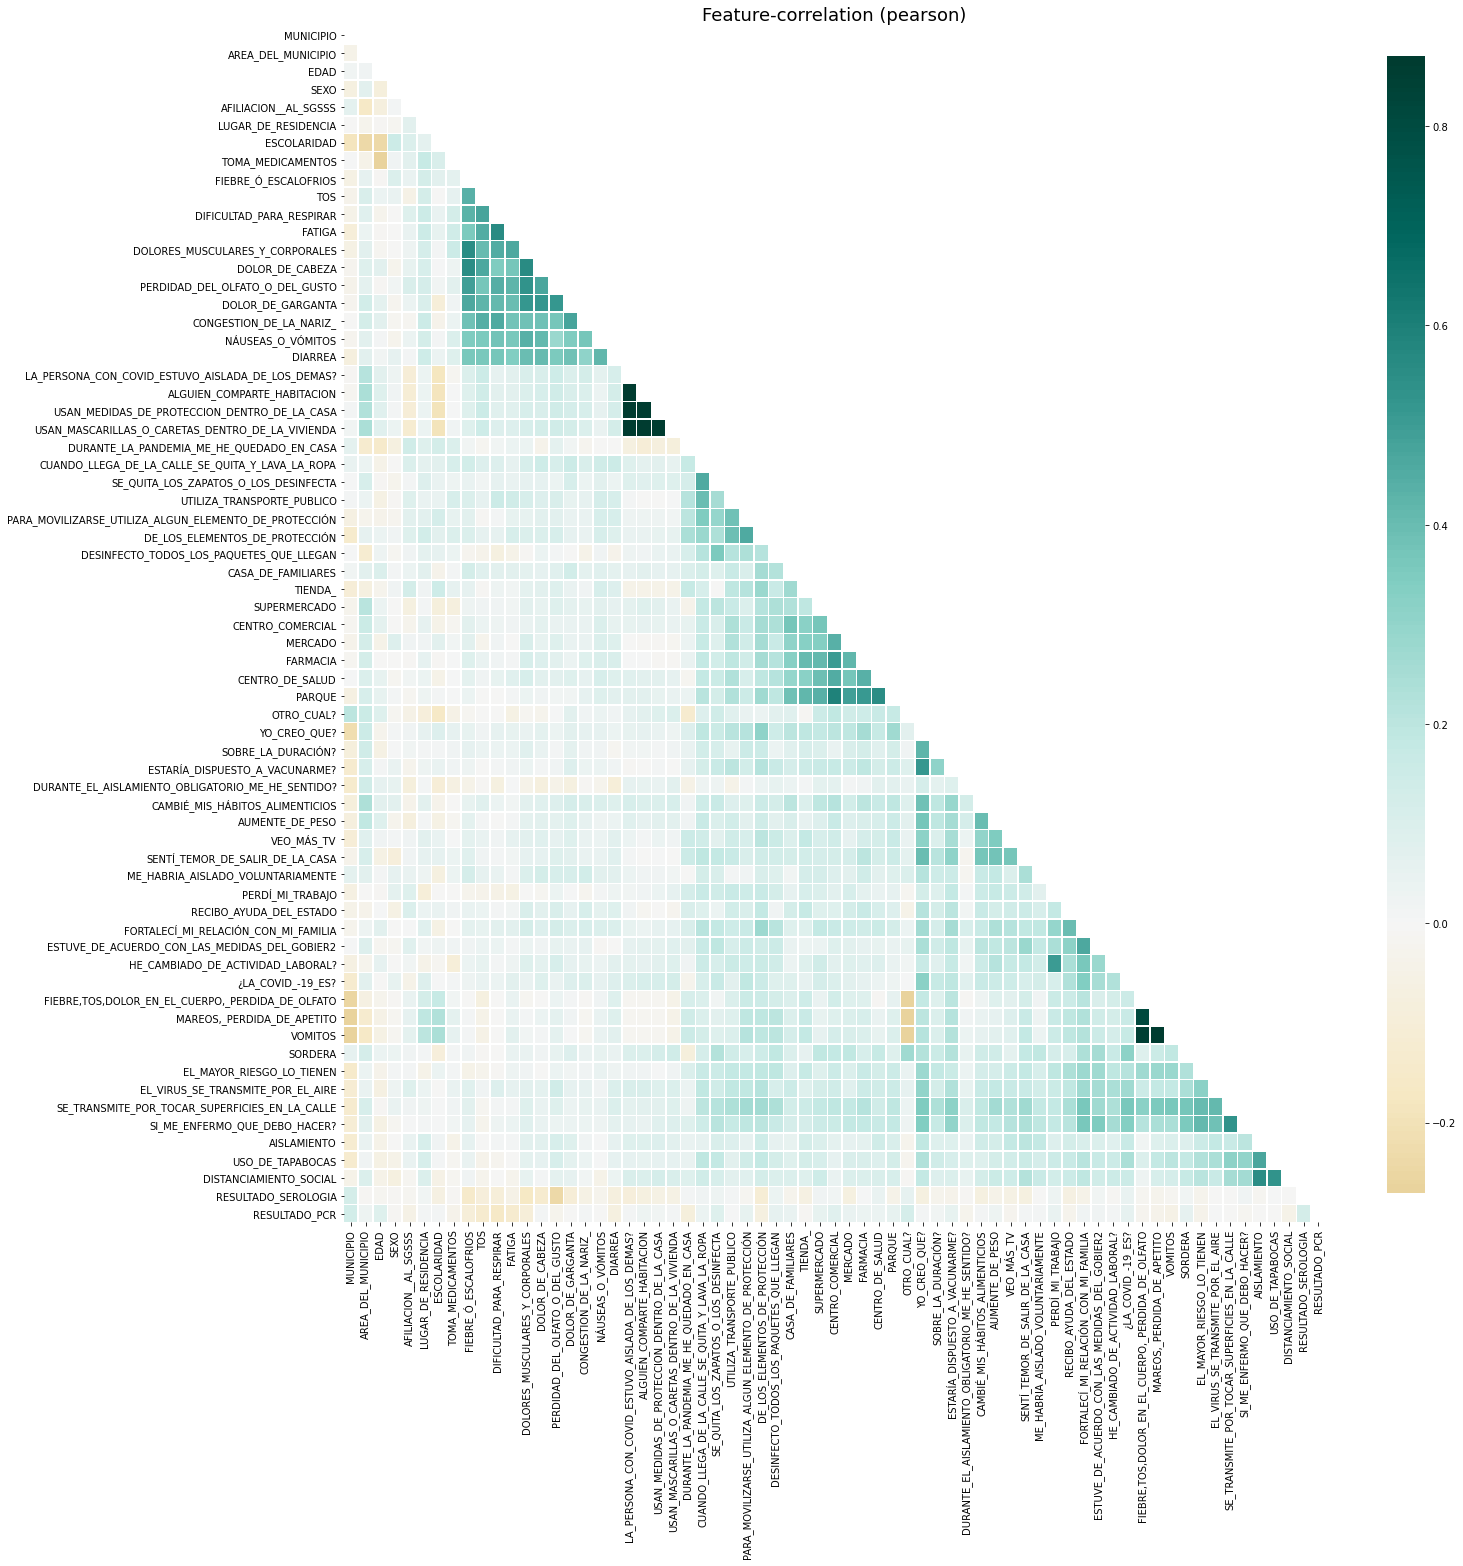

In [ ]:
klib.corr_plot(ready_df,annot=False,figsize=(22,22))

### Modelling (EDA) #1

El modelado exploratoro es una técnica que usaremos repetidas veces, por lo que crearemos una función para ello.

In [ ]:
def modelling(data,target_variable,ignore):
    X = data.drop([ignore,target_variable], axis=1)
    y = data[[target_variable]]
    
    seed = 2
    test_size = 0.2
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed,shuffle=True, stratify=y)

    unique , counts = np.unique(y_train, return_counts=True)
    prop=counts[0]/counts[1]
    print('Split Listo', '\n La proporción entre clases es:', prop)

    dtrain = xgb.DMatrix(
            X_train,
            y_train)
    dtest = xgb.DMatrix(
            X_test,
            y_test)

    model = xgb.train({'eta': 0.1,'colsample_bytree' : 1,'sample_type': 'weighted','min_child_weight':1,'max_delta_step':1,'max_depth': 5,
                              'subsample': 0.8,'objective': 'binary:logistic','n_estimators':1,'scale_pos_weight':prop,'num_parallel_tree':2,
                              'gamma': 10,'alpha' : 20,'lambda': 50,'silent': 1,'verbosity': 0,'tree_method':'hist', 'grow_policy':'depthwise',
                              'max_bin':200},dtrain,num_boost_round=500, evals=[(dtrain, 'train'),(dtest,'test')],verbose_eval=False)

    prediction = model.predict(dtest)
    auc = roc_auc_score(y_test, prediction)
    
    print('Un ejemplo de árbol de decisión.')
    fig, ax = plt.subplots(figsize=(10, 10))
    xgb.plot_tree(model, num_trees=4, ax=ax)
    plt.show() 

    return print('AUC Score: ',auc),plot_importance(model, height=0.2, max_num_features=20)

In [ ]:
modelling(ready_df, 'RESULTADO_PCR','RESULTADO_SEROLOGIA')

NameError: ignored